In [2]:
import os
import csv

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import keras
import tensorflow as tf
import random as python_random
from keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

import pandas.io.sql as sqlio
import psycopg2
import getpass

import matplotlib.pyplot as plt

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 1. Load data

In [4]:
# Define MIMIC data path
data_path = '../mimic_data/'

# Load training data
train_pos = pd.read_csv(data_path+'train_pos.txt', header=None)
train_neg = pd.read_csv(data_path+'train_neg.txt', header=None)

# Add target class label
train_pos['survival'] = [1 for i in range(train_pos.shape[0])]
train_neg['survival'] = [0 for i in range(train_neg.shape[0])]

In [5]:
train_pos.shape

(2818, 2)

In [6]:
# Concat into one data frame; and reorder it
train = pd.concat([train_pos, train_neg]).reset_index()
train_reordered = train.sample(frac=1, random_state=3)

X_train, y_train = train_reordered[0], train_reordered['survival']

In [7]:
X_train.head()

3249    225828  226364  225975  225907  225975  225850...
1754    221744  226364  225828  221744  221668  225974...
3139    225942  221668  227522  225166  226361  221668...
2491    225828  226375  226364  225168  225828  225975...
3914    226361  225166  225798  225883  225906  225883...
Name: 0, dtype: object

In [8]:
# Load validation data
validation_pos = pd.read_csv(data_path+'validation_pos.txt', header=None)
validation_neg = pd.read_csv(data_path+'validation_neg.txt', header=None)

# Add target class
validation_pos['survival'] = [1 for i in range(validation_pos.shape[0])]
validation_neg['survival'] = [0 for i in range(validation_neg.shape[0])]

In [9]:
validation = pd.concat([validation_pos, validation_neg]).reset_index()
validation_reordered = validation.sample(frac=1, random_state=3)

X_val, y_val = validation_reordered[0], validation_reordered['survival']

In [10]:
X_val.head()

376    225827  226375  225884  225974  223258  225907...
16     225910  225855  220970  220970  225168  225168...
365       221794  225828  221794  225834 5551  3932  403
82     221986  226361  225166  227522  225166  227522...
107    226453  225799  225883  223262  225975  225799...
Name: 0, dtype: object

### Data preprocessing

#### 1.1 Conver all the events into sequence (token) ids

In [11]:
# Set the vocab size and max sequence lenght
vocab_size = 1100 #(max vocab id=1024 in the training data)
max_seq_length = 74 #(the maximum sequence length in training/testing data)

In [12]:
# Use a text tokenizer to convert events
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

In [13]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [14]:
# Before texts_to_sequences()
print(f'Before texts_to_sequences():\n {X_train.iloc[0]}\n')

# After texts_to_sequences()
print(f'After texts_to_sequences():\n {X_train_sequences[0]}')

Before texts_to_sequences():
 225828  226364  225975  225907  225975  225850  225907  225975  225850  225168  225907  225828  225975  225828  221794  225975  227523  222011  225975 3259  4029  8674  3420

After texts_to_sequences():
 [5, 31, 3, 33, 3, 21, 33, 3, 21, 13, 33, 5, 3, 5, 10, 3, 20, 12, 3, 379, 495, 380, 328]


#### 1.2 Padding converted sequences

In [15]:
# Pad X_train_sequences and X_val_sequences
X_train_padded = sequence.pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(X_val_sequences, maxlen=max_seq_length, padding='post')

In [16]:
X_train_padded.shape

(4039, 74)

In [17]:
X_val_padded.shape

(400, 74)

In [18]:
X_val_padded[0]

array([198, 116,  29,  16,   1,  33,  21,   3, 198,  16,   1, 198,  29,
        16,  21,  16,   3,  33,  29,  21, 198, 198,   3,  16,  29, 416,
       217, 417,  34,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

## 2. Train the main LSTM model for survival prediction

In [19]:
# For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [20]:
# Fix the random seeds to get consistent models
## ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value = 3

os.environ['PYTHONHASHSEED']=str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(seed_value)

# The below set_seed() will make random number generation
tf.random.set_seed(seed_value)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

def reset_seeds(seed_value=3):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    np.random.seed(seed_value) 
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

reset_seeds() 

In [21]:
# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [22]:
# Define the model structure
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_size, 128)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
main_model = keras.Model(inputs, outputs)

main_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         140800    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 338,561
Trainable params: 338,561
Non-trainable

In [23]:
main_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

reset_seeds()
model_history = main_model.fit(
    X_train_padded, 
    y_train, 
    epochs=30, 
    batch_size=64, 
    validation_data=(X_val_padded, y_val), 
    callbacks=[early_stopping]
    )

Epoch 1/30
64/64 [==============================] - 19s 53ms/step - loss: 0.5811 - accuracy: 0.7017 - val_loss: 0.6780 - val_accuracy: 0.5725
Epoch 2/30
64/64 [==============================] - 2s 39ms/step - loss: 0.5098 - accuracy: 0.7363 - val_loss: 0.5976 - val_accuracy: 0.6850
Epoch 3/30
64/64 [==============================] - 2s 38ms/step - loss: 0.4842 - accuracy: 0.7581 - val_loss: 0.5840 - val_accuracy: 0.6825
Epoch 4/30
64/64 [==============================] - 2s 38ms/step - loss: 0.4522 - accuracy: 0.7923 - val_loss: 0.6770 - val_accuracy: 0.6625
Epoch 5/30
64/64 [==============================] - 2s 39ms/step - loss: 0.4274 - accuracy: 0.8051 - val_loss: 0.6710 - val_accuracy: 0.6400


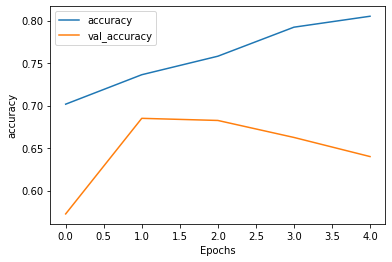

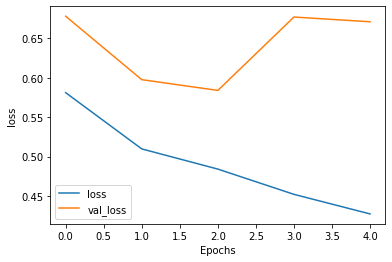

In [24]:
# Visualize the training/validation accuracy and loss
plot_graphs(model_history, "accuracy")
plot_graphs(model_history, "loss")

In [25]:
# Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
y_pred = np.array([1 if pred > 0.5 else 0 for pred in main_model.predict(X_val_padded)])

In [26]:
# Calculate the validation accuracy
validation_acc = sum(y_pred == y_val)/len(y_val)
validation_acc

0.64

In [27]:
# Get the confusion matrix
confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
confusion_matrix_df

,Pred:pos,Pred:neg
True:pos,173,27
True:neg,117,83


In [28]:
# Counts of positive and negative predictions
pd.value_counts(y_pred)

1    290
0    110
dtype: int64

## 3. Get the negative predictions from LSTM, for counterfactual explanations

In [29]:
# Get these instances of negative predictions
X_pred_negative = X_val_padded[y_pred == 0]

In [30]:
X_pred_negative.shape

(110, 74)

#### Export as the desired input format of the DRG framework

In [31]:
# Convert negatively predicted instances back to medical event form
original_event_sequences = tokenizer.sequences_to_texts(X_pred_negative)

In [32]:
original_event_sequences[:5]

['221986 226361 225166 227522 225166 227522 221794 221986 225975 227694 225166 227522 221986 225975 225913 221986 225166 227522 225166 227522 227522 225166 221986 225974 221986 3723 8856 3897',
 '221906 222315 221289 221662 225152 220995 227533 221906 225910 222062 221456 222062 221906 221289 221662 221289 225893 221749 220995 3943 3895 9910',
 '221749 226361 223262 223262 223262 221468 226361 221347 221347 223262 223262 223262 221347 221347 225974 221347 221347 221347 221347 9962',
 '225799 226453 225884 226453 225799 225851 225799 225884 225910 225837 226453 225799 227690 225799 226453 225799 225884 226453 227690 225910 226453 225799 225884 225798 225799 226089 226089 226089 225851 225798 0331 3995 966 3893',
 '226089 220995 225835 3323 8844 9929 9229']

In [33]:
pd.DataFrame(original_event_sequences).to_csv(path_or_buf='../mimic_data/test_neg.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')

Here, we need to use the inference script from the DRG framework (instructions in the README file) to modify those 110 negative predictions into positive instances. After that, we import the transformed results as below.

### 3.1 DeleteOnly model results

In [35]:
# Load the transformed data
results_path = '../drg_preds/'
trans_results_delete = pd.read_csv(results_path+'preds', header=None)

In [36]:
X_test_sequences = tokenizer.texts_to_sequences(trans_results_delete[0])

X_test_padded = sequence.pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

### 3.2 DeleteAndRetrieve model results

In [39]:
# Load the transformed data
# TODO change this directory
delete_generate_results_path = '../drg_preds/'
delete_generate_results = pd.read_csv(delete_generate_results_path+'preds', header=None)

In [40]:
X_test_sequences2 = tokenizer.texts_to_sequences(delete_generate_results[0])

X_test_padded2 = sequence.pad_sequences(X_test_sequences2, maxlen=max_seq_length, padding='post')

### 3.3 Use 1NN baseline method to modify the negatively predicted instances

In [61]:
# Fit an unsupervised 1NN with all the positive sequences, using 'hamming' distance
nn_model = NearestNeighbors(n_neighbors=1, metric='hamming')
target_label = 1
X_target_label = X_train_padded[y_train == target_label]

nn_model.fit(X_target_label)

NearestNeighbors(metric='hamming', n_neighbors=1)

In [62]:
# Find the closest neighbor (positive sequence) with the minimum 'hamming' distance, take it as a counterfactual
closest = nn_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_target_label[closest[:, 0]]

trans_results_nn[0]

array([100,  20,  12,   9, 100,  18,   7,   7,  18, 100,   7,  18, 100,
       100, 100,  12,   3,  20, 100,   3, 131, 223,  71, 188,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [63]:
# Rename 'trans_results_nn' to 'X_test_padded3' for result comparison
X_test_padded3 = trans_results_nn

### 3.4 Convert transformed results to event sequence format

In [64]:
# Convert transformed sequences back to the form of original event sequences
trans_event_sequences1 = tokenizer.sequences_to_texts(X_test_padded)
trans_event_sequences2 = tokenizer.sequences_to_texts(X_test_padded2)
trans_event_sequences3 = tokenizer.sequences_to_texts(X_test_padded3)

## 4. Results comparison

### 4.1 Comparison between fraction of valid CFs (i.e. successfully generated counterfactuals)

In [65]:
# Get the total counts 
test_size = X_pred_negative.shape[0]

In [66]:
# Fraction of valid transformed sequences, for DeleteOnly
fraction_success = np.sum(main_model.predict(X_test_padded) > 0.5)/test_size
print(round(fraction_success, 4))

1.3364


In [67]:
# For DeleteAndRetrieve
fraction_success2 = np.sum(main_model.predict(X_test_padded2) > 0.5)/test_size
print(round(fraction_success2, 4))

1.3364


In [68]:
# For 1NN modification
fraction_success3 = np.sum(main_model.predict(X_test_padded3) > 0.5)/test_size
print(round(fraction_success3, 4))

0.8


### 4.2 Local outlier factor (LOF score)

In [69]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train_padded)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [70]:
# Get the LOF score for leave-out validation data
y_pred_val = clf.predict(X_val_padded)

n_error_val = y_pred_val[y_pred_val == -1].size

In [71]:
validation_size = X_val_padded.shape[0]
outlier_score_val = n_error_val/validation_size

outlier_score_val

0.075

In [72]:
# Get the LOF score for DeleteOnly results
y_pred_test = clf.predict(X_test_padded)
n_error_test = y_pred_test[y_pred_test == -1].size

outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.0818


In [73]:
# Get the outlier score for DeleteAndRetrieve results
y_pred_test2 = clf.predict(X_test_padded2)
n_error_test2 = y_pred_test2[y_pred_test2 == -1].size

outlier_score_test2 = n_error_test2 / test_size
print(round(outlier_score_test2, 4))

0.0818


In [74]:
# Outlier score for 1NN baseline method
y_pred_test3 = clf.predict(X_test_padded3)
n_error_test3 = y_pred_test3[y_pred_test3 == -1].size

outlier_score_test3 = n_error_test3 / test_size
print(round(outlier_score_test3, 4))

0.0364


### 4.3 BLEU-4 score (cumulative 4-gram BLEU score) 

In [75]:
# Define smoothing function
chencherry = SmoothingFunction()

In [76]:
# Define a function to get pairwise BLEU scores
def get_pairwise_bleu(original, transformed):
    # 'weights=[0.25, 0.25, 0.25, 0.25]' means that calculate 4-gram BLEU scores cumulatively
    results = [sentence_bleu(
        references=[pair[0].split()], 
        hypothesis=pair[1].split(), 
        weights=[0.25, 0.25, 0.25, 0.25], 
        smoothing_function=chencherry.method1) 
        for pair in zip(original, transformed)]
    
    return results

In [77]:
pairwise_bleu = get_pairwise_bleu(original_event_sequences, trans_event_sequences1)
avg_bleu = sum(pairwise_bleu)/test_size
print(round(avg_bleu, 4))

0.0059


In [78]:
pairwise_bleu2 = get_pairwise_bleu(original_event_sequences, trans_event_sequences2)
avg_bleu2 = sum(pairwise_bleu2)/test_size
print(round(avg_bleu2, 4))

0.0059


In [79]:
pairwise_bleu3 = get_pairwise_bleu(original_event_sequences, trans_event_sequences3)
avg_bleu3 = sum(pairwise_bleu3)/test_size
print(round(avg_bleu3, 4))

0.0655


#### 4.3.1 Plot histograms of individual BLEU-4 scores

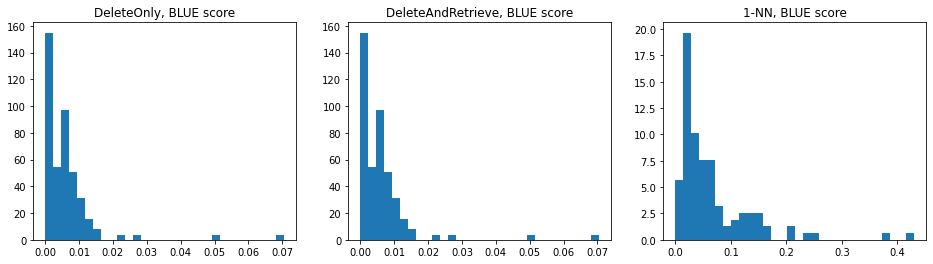

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))     

plt.sca(ax[0])
plt.title('DeleteOnly, BLUE score')
plt.hist(pairwise_bleu, density=True, bins=30)

plt.sca(ax[1])
plt.title('DeleteAndRetrieve, BLUE score')
plt.hist(pairwise_bleu2, density=True, bins=30)

plt.sca(ax[2])
plt.title('1-NN, BLUE score')
plt.hist(pairwise_bleu3, density=True, bins=30)

plt.show()

### 4.4 Plot histograms of event count differences (modification counts)

In [81]:
# The counts of total, drug events and procedures, for the original sequences
original_counts = pd.DataFrame(columns=['total', 'drug', 'procedure'])

In [82]:
def get_counts_table(event_sequences):
    temp_list = list()
    for seq in event_sequences:
        splitted = seq.split()
        total = len(splitted)
        # MetaVision ITEMID values are all above 220000. Since this data only contains data from MetaVision, it only contains ITEMID above 220000
        drug = len([x for x in splitted if int(x)>=220000])
        procedure = total - drug

        temp_list.append({'total': total, 'drug': drug, 'procedure': procedure})
    
    return pd.DataFrame(temp_list)

In [83]:
df_original_counts = get_counts_table(original_event_sequences)

In [84]:
df_original_counts.head()

,total,drug,procedure
0,28,25,3
1,22,19,3
2,20,19,1
3,34,30,4
4,7,3,4


In [85]:
# Get count tables for all the tranformed results (generated counterfactuals)
trans_counts1 = get_counts_table(trans_event_sequences1)
trans_counts2 = get_counts_table(trans_event_sequences2)
trans_counts3 = get_counts_table(trans_event_sequences3)

In [86]:
# Substract the original counts to get event modifications for total, drug events and procedures
substracted1 = trans_counts1.subtract(df_original_counts)
substracted2 = trans_counts2.subtract(df_original_counts)
substracted3 = trans_counts3.subtract(df_original_counts)

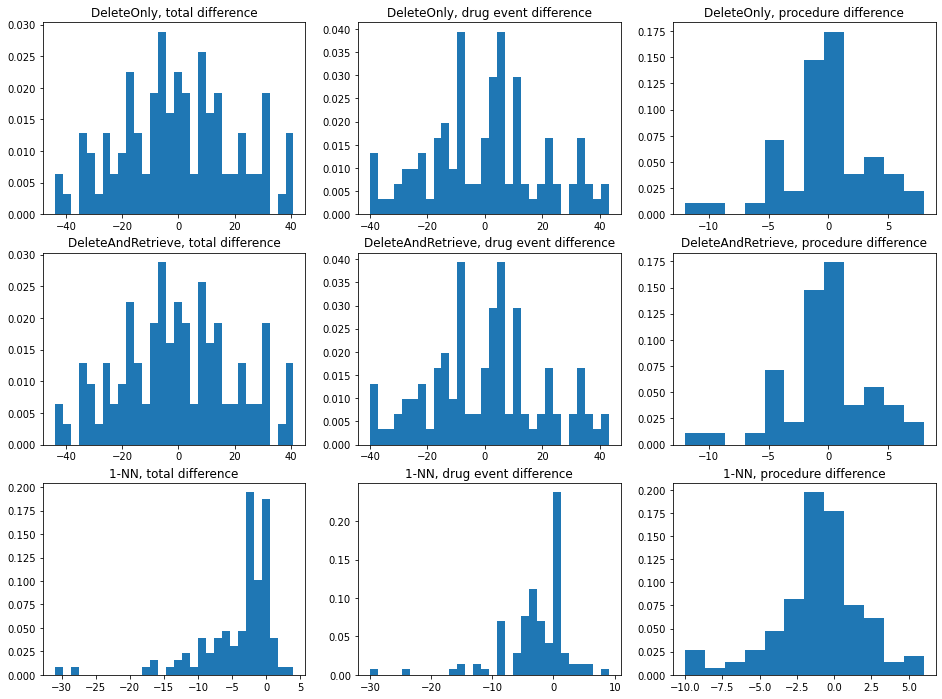

In [87]:
# Plot 3x3 subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,12))

plt.sca(ax[0,0])
plt.title('DeleteOnly, total difference')
plt.hist(substracted1['total'], density=True, bins=30)

plt.sca(ax[0,1])
plt.title('DeleteOnly, drug event difference')
plt.hist(substracted1['drug'], density=True, bins=30)

plt.sca(ax[0,2])
plt.title('DeleteOnly, procedure difference')
plt.hist(substracted1['procedure'], density=True, bins=12)

plt.sca(ax[1,0])
plt.title('DeleteAndRetrieve, total difference')
plt.hist(substracted2['total'], density=True, bins=30)

plt.sca(ax[1,1])
plt.title('DeleteAndRetrieve, drug event difference')
plt.hist(substracted2['drug'], density=True, bins=30)

plt.sca(ax[1,2])
plt.title('DeleteAndRetrieve, procedure difference')
plt.hist(substracted2['procedure'], density=True, bins=12)

plt.sca(ax[2,0])
plt.title('1-NN, total difference')
plt.hist(substracted3['total'], density=True, bins=30)

plt.sca(ax[2,1])
plt.title('1-NN, drug event difference')
plt.hist(substracted3['drug'], density=True, bins=30)

plt.sca(ax[2,2])
plt.title('1-NN, procedure difference')
plt.hist(substracted3['procedure'], density=True, bins=12)

plt.show()

### 4.5 Export example counterfactuals 

In [90]:
# Convert id to original event name
conn = psycopg2.connect(
    database="mimic", 
    user='postgres',
    password=getpass.getpass("Enter postgres password"), 
    host="127.0.0.1", 
    port="5432",
    options=f'-c search_path=mimiciii')

In [91]:
# Get a mapping from itemid to name (drug events)
itemid_to_name = pd.read_sql(
    """
    SELECT itemid, abbreviation, label
    FROM d_items;
    """, conn)

itemid_to_name = itemid_to_name[itemid_to_name['itemid'] >= 220000]
itemid_to_name.head()

,itemid,abbreviation,label
8673,221015,Ensure,Ensure
8674,221016,Ensure Plus,Ensure Plus
8675,221017,"Dextrose 2,5%","Dextrose 2,5%"
8676,225166,Potassium Chloride - KCL,Potassium Chloride
8677,225167,Hydrochloric Acid - HCL,Hydrochloric Acid - HCL


In [92]:
# Get another mapping from procedure itemid to name 
itemid_to_name2 = pd.read_sql(
    """
    SELECT icd9_code, short_title, long_title
    FROM d_icd_procedures;
    """, conn)

itemid_to_name2.head()

,icd9_code,short_title,long_title
0,0851,Canthotomy,Canthotomy
1,0852,Blepharorrhaphy,Blepharorrhaphy
2,0859,Adjust lid position NEC,Other adjustment of lid position
3,0861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,0862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...


In [93]:
# Concate two itemid_to_name into one table
itemid_to_name2 = itemid_to_name2.rename(columns={'icd9_code': 'itemid', 'short_title': 'abbreviation', 'long_title': 'label'})

itemid_to_name_concat = pd.concat([itemid_to_name, itemid_to_name2])

In [94]:
# Convert data type to be consistent when filtering, e.g. 'itemid_to_name_concat['itemid'] == 9671'
itemid_to_name_concat['label'] = itemid_to_name_concat['label'].astype('str') 
itemid_to_name_concat['itemid'] = itemid_to_name_concat['itemid'].astype('int') 

In [95]:
# Define a method to convert event codes to original names
def code_to_name(event_sequence):
    code_sequence = [int(event) for event in event_sequence.split()]
    
    temp_list = list()
    for code in code_sequence:
        event_name = itemid_to_name_concat[itemid_to_name_concat['itemid'] == code]['label'].item()
        temp_list.append(event_name)
    
    return temp_list

In [96]:
# Get the sample for example counterfactuals
sample_id = 44

In [97]:
code_to_name(original_event_sequences[sample_id])

['Heparin Sodium',
 'Pre-Admission Intake',
 'Metoprolol',
 'Metoprolol',
 'Metoprolol',
 'Heparin Sodium',
 'Heparin Sodium',
 'Interruption of the vena cava']

In [98]:
# original_event_sequences[sample_id]

In [99]:
code_to_name(trans_event_sequences1[sample_id])

['Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Calcium Gluconate',
 'Piggyback',
 'Calcium Gluconate',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'D5NS',
 'Calcium Gluconate',
 'Piggyback',
 'Dilantin',
 'Heparin Sodium (Prophylaxis)',
 'Dilantin',
 'Dilantin',
 'Metoprolol',
 'Heparin Sodium (Prophylaxis)',
 'Continuous invasive mechanical ventilation for less than 96 consecutive hours',
 'Bronchial dilation',
 'Other intubation of respiratory tract']

In [100]:
# trans_event_sequences1[sample_id]

In [101]:
code_to_name(trans_event_sequences2[sample_id])

['Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Calcium Gluconate',
 'Piggyback',
 'Calcium Gluconate',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'D5NS',
 'Calcium Gluconate',
 'Piggyback',
 'Dilantin',
 'Heparin Sodium (Prophylaxis)',
 'Dilantin',
 'Dilantin',
 'Metoprolol',
 'Heparin Sodium (Prophylaxis)',
 'Continuous invasive mechanical ventilation for less than 96 consecutive hours',
 'Bronchial dilation',
 'Other intubation of respiratory tract']

In [102]:
# trans_event_sequences2[sample_id]

In [103]:
code_to_name(trans_event_sequences3[sample_id])

['Heparin Sodium',
 'Magnesium Sulfate (Bolus)',
 'Magnesium Sulfate',
 'Magnesium Sulfate (Bolus)',
 'Magnesium Sulfate',
 'Heparin Sodium',
 'Combined right and left heart cardiac catheterization',
 'Coronary arteriography using two catheters']

In [104]:
# trans_event_sequences3[sample_id]